### SSH based plots and sections 


In [1]:
import numpy as np
import xarray as xr

import glidertools as gt
from cmocean import cm as cmo

import gsw

import matplotlib.pyplot as plt

In [2]:
plt.style.use('seaborn-colorblind')
plt.rcParams['font.size'] = 16

In [3]:
def datetime2ytd(time):
    """" Return time in YTD format from datetime format."""
    return  (time - np.datetime64('2019-01-01'))/np.timedelta64(1, 'D')
    

In [4]:
ds_659_z = xr.open_dataset('data/sg_659_vert_4m_binned_geoff_cleaned_24_sept_2021.nc')
ds_660_z = xr.open_dataset('data/sg_660_vert_4m_binned_geoff_cleaned_24_sept_2021.nc')
# Calculate a time axis as YTD
ds_659_z['days'] = datetime2ytd(ds_659_z.time)
ds_660_z['days'] = datetime2ytd(ds_660_z.time)

In [5]:
ds_SSH = xr.open_dataset('/Users/dhruvbalwada/OneDrive/sogos_data/data/for_dashboard/SSH_sogos.nc')
ds_SSH = ds_SSH.assign_coords(days = datetime2ytd(ds_SSH.time))

### Convert from dives to time

In [20]:
# Interpolate to a uniform time grid
from scipy import interpolate

def interp_time(ds, var): 
    time_grid = np.arange(121, 205, 1/24)

   
    for i in range(len(ds.ctd_pressure)):
        ds_temp =ds.isel(ctd_pressure=i)
        
        f = interpolate.interp1d(ds_temp.days, ds_temp[var])
        var_int = f(time_grid)
        
        da_var_int_temp = xr.DataArray(var_int,
                                 dims=["days"],
                                 coords={"days": time_grid, "ctd_pressure": ds_temp.ctd_pressure}
                                 ).rename(var)
        
        if i==0:
            da_var_int = da_var_int_temp
        else:
            da_var_int = xr.concat([da_var_int, da_var_int_temp], dim='ctd_pressure')
        
    return da_var_int

In [21]:
ds_660_time = xr.merge([interp_time(ds_660_z,'sigma0'),
                        interp_time(ds_660_z,'CT'),
                        interp_time(ds_660_z,'SA'),
                        interp_time(ds_660_z,'dives'),
                        interp_time(ds_660_z,'longitude'),
                        interp_time(ds_660_z,'latitude')])

In [22]:
ds_659_time = xr.merge([interp_time(ds_659_z,'sigma0'),
                        interp_time(ds_659_z,'CT'),
                        interp_time(ds_659_z,'SA'),
                        interp_time(ds_659_z,'dives'),
                        interp_time(ds_659_z,'longitude'),
                        interp_time(ds_659_z,'latitude')])

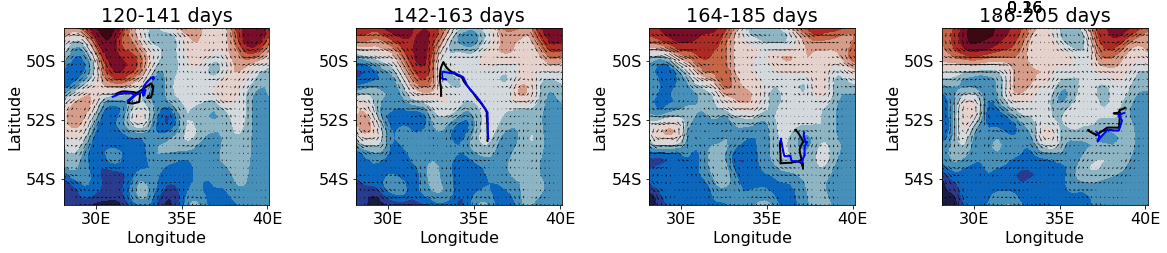

In [27]:
plt.figure(figsize=(2.2*7.5, 3.8))

plt.subplot(141)
ds_SSH.adt.isel(time=slice(0, 21)).mean('time').plot.contourf(levels=np.linspace(-1.2,0, 13), cmap=cmo.balance,
                                                             add_colorbar=False)
ds_SSH.isel(time=slice(0, 21)).mean('time').plot.quiver(x='longitude', y='latitude', u='ugos', v='vgos')

plt.plot(ds_660_time.sel(days=slice(120,142)).sel(ctd_pressure=200, method='nearest').longitude,
         ds_660_time.sel(days=slice(120,142)).sel(ctd_pressure=200, method='nearest').latitude,
        linewidth=2, color='k')
plt.plot(ds_659_time.sel(days=slice(120,142)).sel(ctd_pressure=200, method='nearest').longitude,
         ds_659_time.sel(days=slice(120,142)).sel(ctd_pressure=200, method='nearest').latitude,
        linewidth=2, color='b')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('120-141 days')
plt.xticks([30, 35, 40], labels=['30E', '35E', '40E'])
plt.yticks([-54, -52, -50], labels=['54S', '52S', '50S'])

plt.subplot(142)
ds_SSH.adt.isel(time=slice(21, 43)).mean('time').plot.contourf(levels=np.linspace(-1.2,0, 13), cmap=cmo.balance,
                                                             add_colorbar=False)
ds_SSH.isel(time=slice(21, 43)).mean('time').plot.quiver(x='longitude', y='latitude', u='ugos', v='vgos')

plt.plot(ds_660_time.sel(days=slice(142,164)).sel(ctd_pressure=200, method='nearest').longitude,
         ds_660_time.sel(days=slice(142,164)).sel(ctd_pressure=200, method='nearest').latitude,
        linewidth=2, color='k')
plt.plot(ds_659_time.sel(days=slice(142,164)).sel(ctd_pressure=200, method='nearest').longitude,
         ds_659_time.sel(days=slice(142,164)).sel(ctd_pressure=200, method='nearest').latitude,
        linewidth=2, color='b')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('142-163 days')
plt.xticks([30, 35, 40], labels=['30E', '35E', '40E'])
plt.yticks([-54, -52, -50], labels=['54S', '52S', '50S'])

plt.subplot(143)
ds_SSH.adt.isel(time=slice(43, 65)).mean('time').plot.contourf(levels=np.linspace(-1.2,0, 13), cmap=cmo.balance,
                                                             add_colorbar=False)
ds_SSH.isel(time=slice(43, 65)).mean('time').plot.quiver(x='longitude', y='latitude', u='ugos', v='vgos')

plt.plot(ds_660_time.sel(days=slice(164,186)).sel(ctd_pressure=200, method='nearest').longitude,
         ds_660_time.sel(days=slice(164,186)).sel(ctd_pressure=200, method='nearest').latitude,
        linewidth=2, color='k')
plt.plot(ds_659_time.sel(days=slice(164,186)).sel(ctd_pressure=200, method='nearest').longitude,
         ds_659_time.sel(days=slice(164,186)).sel(ctd_pressure=200, method='nearest').latitude,
        linewidth=2, color='b')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('164-185 days')
plt.xticks([30, 35, 40], labels=['30E', '35E', '40E'])
plt.yticks([-54, -52, -50], labels=['54S', '52S', '50S'])

plt.subplot(144)
ds_SSH.adt.isel(time=slice(65, 88)).mean('time').plot.contourf(levels=np.linspace(-1.2,0, 13), cmap=cmo.balance,
                                                             add_colorbar=False)#, cbar_kwargs={'label': 'SSH [m]'})
ds_SSH.isel(time=slice(65, 88)).mean('time').plot.quiver(x='longitude', y='latitude', u='ugos', v='vgos')

plt.plot(ds_660_time.sel(days=slice(186,206)).sel(ctd_pressure=200, method='nearest').longitude,
         ds_660_time.sel(days=slice(186,206)).sel(ctd_pressure=200, method='nearest').latitude,
        linewidth=2, color='k')
plt.plot(ds_659_time.sel(days=slice(186,206)).sel(ctd_pressure=200, method='nearest').longitude,
         ds_659_time.sel(days=slice(186,206)).sel(ctd_pressure=200, method='nearest').latitude,
        linewidth=2, color='b')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('186-205 days')
plt.xticks([30, 35, 40], labels=['30E', '35E', '40E'])
plt.yticks([-54, -52, -50], labels=['54S', '52S', '50S'])

plt.tight_layout()

plt.savefig('figures/figure_SSH_panel1.pdf')

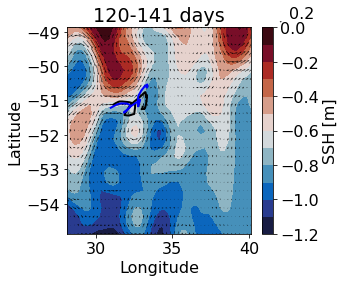

In [30]:
plt.figure(figsize=(2.2*7.5/4, 3.8))

plt.subplot(111)
ds_SSH.adt.isel(time=slice(0, 21)).mean('time').plot.contourf(levels=np.linspace(-1.2,0, 13), cmap=cmo.balance,
                                                             add_colorbar=True, cbar_kwargs={'label': 'SSH [m]'})
ds_SSH.isel(time=slice(0, 21)).mean('time').plot.quiver(x='longitude', y='latitude', u='ugos', v='vgos')

plt.plot(ds_660_time.sel(days=slice(120,142)).sel(ctd_pressure=200, method='nearest').longitude,
         ds_660_time.sel(days=slice(120,142)).sel(ctd_pressure=200, method='nearest').latitude,
        linewidth=2, color='k')
plt.plot(ds_659_time.sel(days=slice(120,142)).sel(ctd_pressure=200, method='nearest').longitude,
         ds_659_time.sel(days=slice(120,142)).sel(ctd_pressure=200, method='nearest').latitude,
        linewidth=2, color='b')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('120-141 days')


plt.savefig('figures/figure_SSH_panel1cbar.pdf')

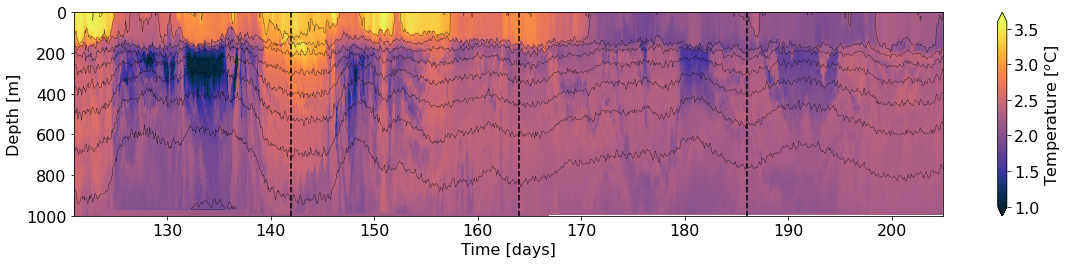

In [33]:
plt.figure(figsize=(2.2*7.5,2.2*1.8))
ds_660_time.CT.plot(cmap=cmo.thermal, rasterized=True, cbar_kwargs={'label': 'Temperature [$^o$C]'}, vmin=1., vmax=3.6)
ds_660_time.sigma0.plot.contour(levels=np.linspace(27.0, 27.9,10), colors='k', linewidths=0.3)
plt.gca().invert_yaxis()

plt.vlines([142, 164, 186], 0, 1000, linestyles='--', colors='k')
#plt.xticks([0, 4e5, 8e5, 12e5, 16e5], labels=[0, 400, 800, 1200, 1600])
plt.xlabel('Time [days]')
plt.ylabel('Depth [m]')

plt.tight_layout()

plt.savefig('figures/figure_SSH_panel2.pdf')

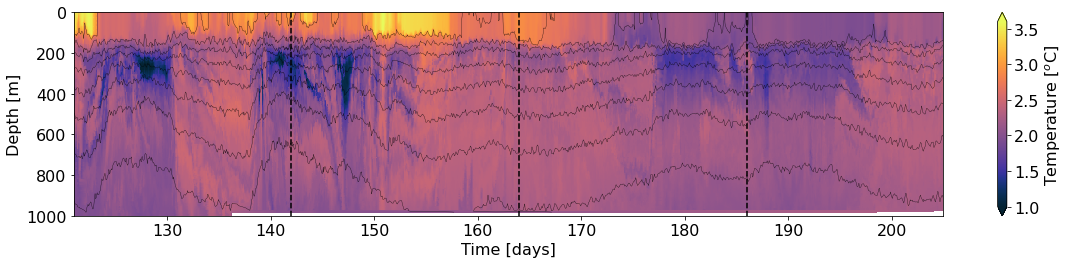

In [34]:
plt.figure(figsize=(2.2*7.5,2.2*1.8))
ds_659_time.CT.plot(cmap=cmo.thermal, rasterized=True, cbar_kwargs={'label': 'Temperature [$^o$C]'}, vmin=1., vmax=3.6)
ds_659_time.sigma0.plot.contour(levels=np.linspace(27.0, 27.9,10), colors='k', linewidths=0.3)
plt.gca().invert_yaxis()

plt.vlines([142, 164, 186], 0, 1000, linestyles='--', colors='k')
#plt.xticks([0, 4e5, 8e5, 12e5, 16e5], labels=[0, 400, 800, 1200, 1600])
plt.xlabel('Time [days]')
plt.ylabel('Depth [m]')

plt.tight_layout()

plt.savefig('figures/figure_SSH_panel3.pdf')

### Scraps

In [ ]:
plt.figure(figsize=(2.2*7.5, 6))

plt.subplot(121)
ds_SSH.adt.isel(time=slice(0, 30)).mean('time').plot.contourf(levels=np.linspace(-1.2,0, 13), cmap=cmo.balance)
ds_SSH.isel(time=slice(0, 30)).mean('time').plot.quiver(x='longitude', y='latitude', u='ugos', v='vgos')

plt.plot(ds_660_z.where(ds_660_z.days<=150, drop=True).sel(ctd_pressure=200, method='nearest').longitude,
         ds_660_z.where(ds_660_z.days<=150, drop=True).sel(ctd_pressure=200, method='nearest').latitude)


plt.subplot(122)
#ds_660_z.where(ds_660_z.days<=150, drop=True).CT.plot(cmap=cmo.thermal, vmin=1, vmax=3.2, rasterized=True)
ds_660_time.CT.sel(days = slice(119, 150)).plot(cmap=cmo.thermal, vmin=1, vmax=3.2, rasterized=True)
plt.gca().invert_yaxis()

plt.tight_layout()

#plt.savefig('./figures/ssh_sec1.pdf')

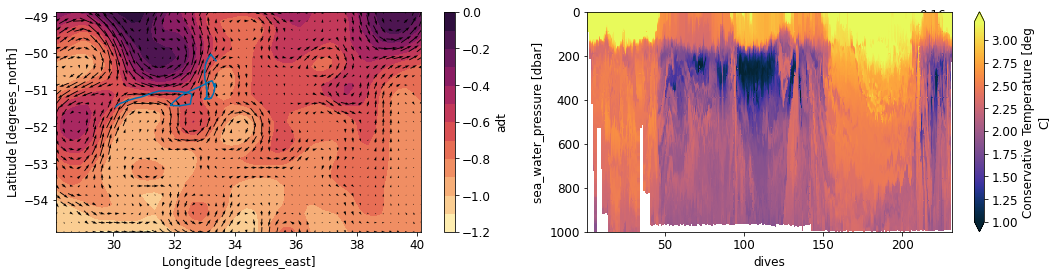

In [20]:
plt.figure(figsize=(15, 4))

plt.subplot(121)
ds_SSH.adt.isel(time=slice(0, 30)).mean('time').plot.contourf(levels=np.linspace(-1.2,0, 13), cmap=cmo.matter)
ds_SSH.isel(time=slice(0, 30)).mean('time').plot.quiver(x='longitude', y='latitude', u='ugos', v='vgos')
plt.plot(ds_660_time.where(ds_660_z.days<=150, drop=True).sel(ctd_pressure=200, method='nearest').longitude,
         ds_660_z.where(ds_660_z.days<=150, drop=True).sel(ctd_pressure=200, method='nearest').latitude)


plt.subplot(122)
ds_660_z.where(ds_660_z.days<=150, drop=True).CT.plot(cmap=cmo.thermal, vmin=1, vmax=3.2, rasterized=True)
plt.gca().invert_yaxis()

plt.tight_layout()

#plt.savefig('./figures/ssh_sec1.pdf')

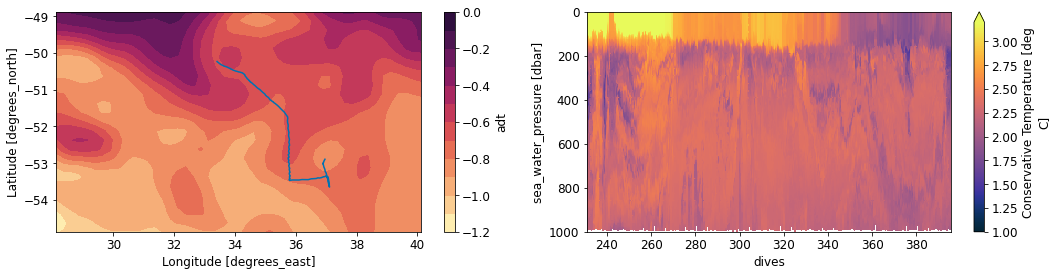

In [77]:
plt.figure(figsize=(15, 4))

ds_660_sel = ds_660_z.where( (ds_660_z.days>=150) & (ds_660_z.days<=180), drop=True)

plt.subplot(121)
ds_SSH.adt.isel(time=slice(30, 60)).mean('time').plot.contourf(levels=np.linspace(-1.2,0, 13), cmap=cmo.matter)
plt.plot(ds_660_sel.sel(ctd_pressure=200, method='nearest').longitude,
         ds_660_sel.sel(ctd_pressure=200, method='nearest').latitude)

plt.subplot(122)
ds_660_sel.CT.plot(cmap=cmo.thermal, vmin=1, vmax=3.2, rasterized=True)
plt.gca().invert_yaxis()

plt.tight_layout()
plt.savefig('./figures/ssh_sec2.pdf')

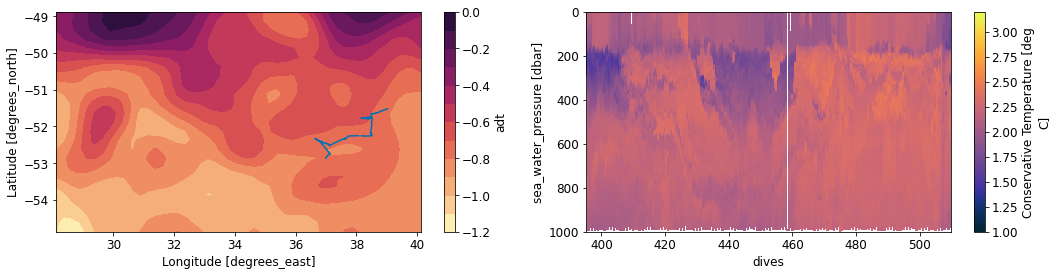

In [79]:
plt.figure(figsize=(15, 4))

ds_660_sel = ds_660_z.where( (ds_660_z.days>=180), drop=True)

plt.subplot(121)
ds_SSH.adt.isel(time=slice(60, 90)).mean('time').plot.contourf(levels=np.linspace(-1.2,0, 13), cmap=cmo.matter)
plt.plot(ds_660_sel.sel(ctd_pressure=200, method='nearest').longitude,
         ds_660_sel.sel(ctd_pressure=200, method='nearest').latitude)

plt.subplot(122)
ds_660_sel.CT.plot(cmap=cmo.thermal, vmin=1, vmax=3.2, rasterized=True)
plt.gca().invert_yaxis()

plt.tight_layout()
plt.savefig('./figures/ssh_sec3.pdf')